Hierachical Logistic Regression
================================

Let's set some setting for this Jupyter Notebook.

In [3]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Now, let's import the `HierarchicalLogisticRegression` model from the `pymc-learn` package.

In [4]:
import pmlearn
from pmlearn.linear_model import HierarchicalLogisticRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

In [5]:
num_pred = 2
num_samples = 700000
num_categories = 2

In [6]:
alphas = 5 * np.random.randn(num_categories) + 5 # mu_alpha = sigma_alpha = 5
betas = 10 * np.random.randn(num_categories, num_pred) + 10 # mu_beta = sigma_beta = 10

In [7]:
alphas

array([ 3.9764617 ,  7.39471669])

In [8]:
betas

array([[  4.80561285,   4.44269696],
       [ 29.65780573,  23.93405833]])

In [9]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [10]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

X = np.concatenate([x_a, x_b])
y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, cats_train, cats_test = train_test_split(X, y, cats, test_size=0.3)

## Step 2: Instantiate a model

In [12]:
model = HierarchicalLogisticRegression()

## Step 3: Perform Inference

In [13]:
model.fit(X_train, y_train, cats_train, minibatch_size=2000, inference_args={'n': 60000})

Average Loss = 246.46: 100%|██████████| 60000/60000 [02:19<00:00, 429.21it/s]
Finished [100%]: Average Loss = 246.56


HierarchicalLogisticRegression()

## Step 4: Diagnose convergence

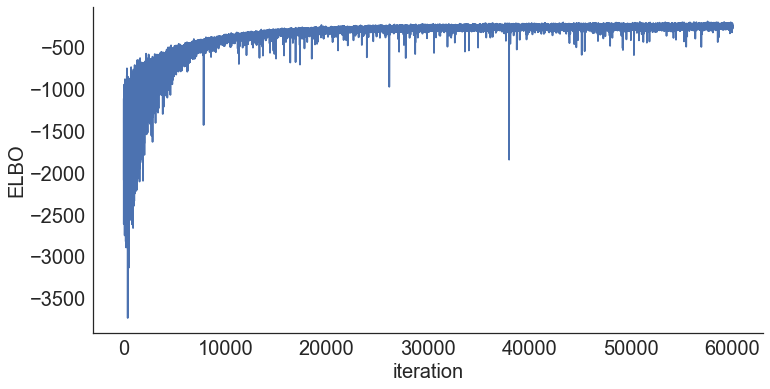

In [14]:
model.plot_elbo()

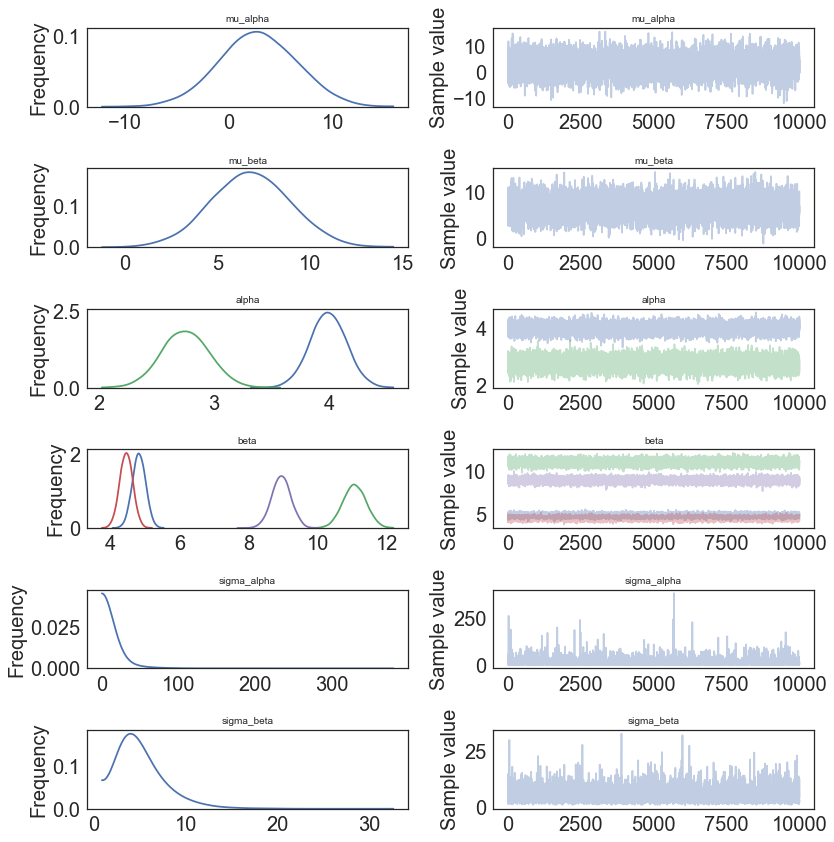

In [15]:
pm.traceplot(model.trace);

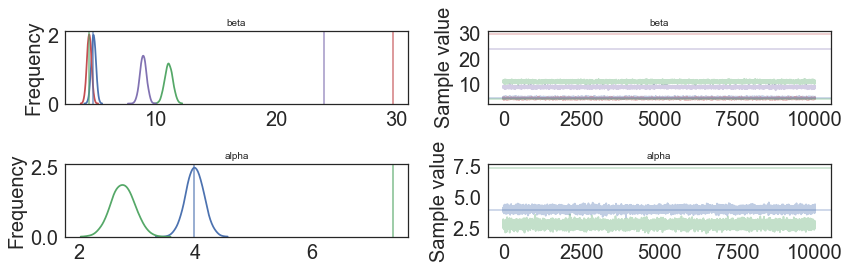

In [16]:
pm.traceplot(model.trace, lines = {"beta": betas, 
                                 "alpha": alphas}, 
             varnames=["beta", "alpha"]);

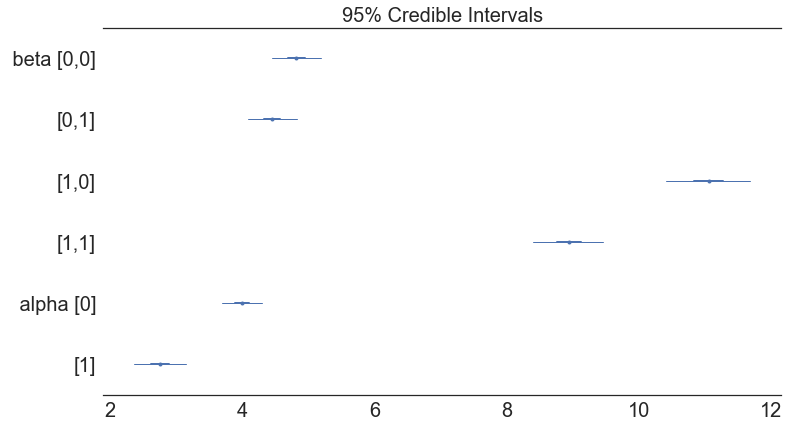

In [17]:
pm.forestplot(model.trace, varnames=["beta", "alpha"]);

## Step 5: Critize the model

In [18]:
pm.summary(model.trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_alpha,2.762447,3.702337,0.035507,-4.345352,10.213894
mu_beta,6.799099,2.119254,0.020894,2.640162,10.953644
alpha__0,3.992272,0.154989,0.001559,3.683080,4.296882
alpha__1,2.753978,0.203159,0.002084,2.356660,3.152206
beta__0_0,4.817129,0.190077,0.001997,4.449666,5.191381
beta__0_1,4.447704,0.186797,0.002043,4.086421,4.817914
beta__1_0,11.057359,0.327623,0.002926,10.413378,11.689952
beta__1_1,8.937158,0.271224,0.002630,8.392272,9.461213
sigma_alpha,11.912198,15.283716,0.165522,0.294809,37.133923
sigma_beta,5.171519,2.691029,0.028385,1.340010,10.425355


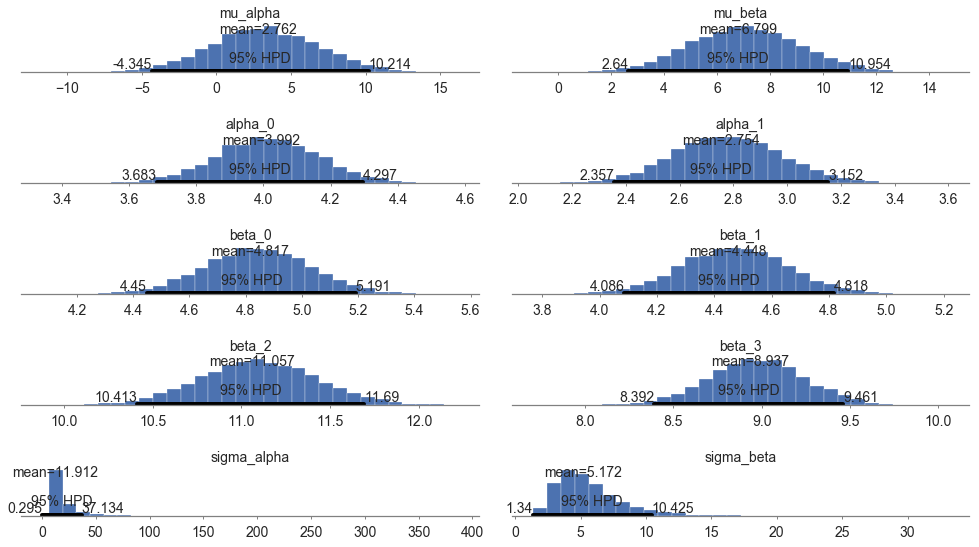

In [19]:
pm.plot_posterior(model.trace, figsize = [14, 8]);

In [20]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["beta", "alpha"],
               "Parameter-Learned (Mean Value)": [model.trace["beta"].mean(axis=0), 
                                model.trace["alpha"].mean(axis=0)],
               "True value": [betas, alphas]})

,Parameter,Parameter-Learned (Mean Value),True value
0,beta,"[[4.81712892701, 4.44770360874], [11.057358919...","[[4.80561284943, 4.44269695653], [29.657805725..."
1,alpha,"[3.99227159692, 2.75397848498]","[3.97646170258, 7.39471669029]"


## Step 6: Use the model for prediction

In [21]:
y_probs = model.predict_proba(X_test, cats_test)

100%|██████████| 2000/2000 [02:07<00:00, 15.50it/s]


In [22]:
y_predicted = model.predict(X_test, cats_test)

100%|██████████| 2000/2000 [02:12<00:00, 15.66it/s]


In [23]:
model.score(X_test, y_test, cats_test)

100%|██████████| 2000/2000 [02:10<00:00, 15.18it/s]


0.95806190476190478

In [24]:
model.save('pickle_jar/hlogistic_model')

#### Use already trained model for prediction

In [25]:
model_new = HierarchicalLogisticRegression()

In [26]:
model_new.load('pickle_jar/hlogistic_model')

In [27]:
model_new.score(X_test, y_test, cats_test)

100%|██████████| 2000/2000 [01:25<00:00, 23.49it/s]


0.95800952380952376

## MCMC

In [ ]:
model2 = HierarchicalLogisticRegression()
model2.fit(X_train, y_train, cats_train, inference_type='nuts')

### Diagnose convergence

In [ ]:
pm.traceplot(model2.trace, lines = {"beta": betas, 
                                 "alpha": alphas}, 
             varnames=["beta", "alpha"]);

In [ ]:
pm.gelman_rubin(model2.trace)

In [ ]:
pm.energyplot(model2.trace);

### Criticize the model

In [ ]:
pm.summary(model2.trace)

In [ ]:
pm.plot_posterior(model2.trace, figsize = [14, 8]);

### Use the model for prediction

In [ ]:
y_predict2 = model2.predict(X_test)

In [ ]:
model2.score(X_test, y_test)

In [ ]:
model2.save('pickle_jar/hlogistic_model2')
model2_new = LogisticRegression()
model2_new.load('pickle_jar/hlogistic_model2')
model2_new.score(X_test, y_test, cats_test)